# **Zomato Data Analysis & Predictive Modeling**
This notebook is an end-to-end data science project. It follows a structured process:
1.  **Data Loading:** Import libraries and load the raw data.
2.  **Data Cleaning:** Identify and fix critical data integrity issues (mixed currencies, 0-values, etc.).
3.  **Exploratory Data Analysis (EDA):** Use statistics and visualizations to find patterns.
4.  **Hypothesis Testing:** Statistically prove or disprove the patterns found in EDA.
5.  **Regression:** Build a model to predict restaurant ratings.
6.  **Clustering:** Discover hidden market segments.

## Phase 1: Data Loading

Import libraries for data manipulation (Pandas, NumPy), visualization (Matplotlib, Seaborn), and machine learning (Scikit-learn).

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

Load the raw `zomato.csv` file. Use `encoding="latin-1"` to handle potential character issues and `df.head()` to confirm it loaded correctly.

In [2]:
try:
    df = pd.read_csv("zomato.csv", encoding="latin-1")
except Exception as e:
    print(f"Error loading file: {e}")

In [3]:
# Check
if 'df' in locals():
    print("File loaded successfully")

File loaded successfully


In [4]:
df.head()

,Restaurant ID,Restaurant Name,City,Address,Locality,Longitude,Latitude,Cuisines,Average Cost for two,Currency,Has Table booking,Has Online delivery,Is delivering now,Price range,Aggregate rating,Rating color,Rating text,Votes
0,6317637,Le Petit Souffle,Makati City,"Third Floor, Century City Mall, Kalayaan Avenu...","Century City Mall, Poblacion, Makati City",121.027535,14.565443,"French, Japanese, Desserts",1100,Botswana Pula(P),Yes,No,No,3,4.8,Dark Green,Excellent,314
1,6304287,Izakaya Kikufuji,Makati City,"Little Tokyo, 2277 Chino Roces Avenue, Legaspi...","Little Tokyo, Legaspi Village, Makati City",121.014101,14.553708,Japanese,1200,Botswana Pula(P),Yes,No,No,3,4.5,Dark Green,Excellent,591
2,6300002,Heat - Edsa Shangri-La,Mandaluyong City,"Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...","Edsa Shangri-La, Ortigas, Mandaluyong City",121.056831,14.581404,"Seafood, Asian, Filipino, Indian",4000,Botswana Pula(P),Yes,No,No,4,4.4,Green,Very Good,270
3,6318506,Ooma,Mandaluyong City,"Third Floor, Mega Fashion Hall, SM Megamall, O...","SM Megamall, Ortigas, Mandaluyong City",121.056475,14.585318,"Japanese, Sushi",1500,Botswana Pula(P),No,No,No,4,4.9,Dark Green,Excellent,365
4,6314302,Sambo Kojin,Mandaluyong City,"Third Floor, Mega Atrium, SM Megamall, Ortigas...","SM Megamall, Ortigas, Mandaluyong City",121.057508,14.584450,"Japanese, Korean",1500,Botswana Pula(P),Yes,No,No,4,4.8,Dark Green,Excellent,229


## Phase 2: Data Cleaning & Scoping

This is the most critical phase. I'll Run `df.info()` to get a high-level diagnostic of the data, look for missing values and incorrect data types.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9551 entries, 0 to 9550
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Restaurant ID         9551 non-null   int64  
 1   Restaurant Name       9551 non-null   object 
 2   City                  9551 non-null   object 
 3   Address               9551 non-null   object 
 4   Locality              9551 non-null   object 
 5   Longitude             9551 non-null   float64
 6   Latitude              9551 non-null   float64
 7   Cuisines              9542 non-null   object 
 8   Average Cost for two  9551 non-null   int64  
 9   Currency              9551 non-null   object 
 10  Has Table booking     9551 non-null   object 
 11  Has Online delivery   9551 non-null   object 
 12  Is delivering now     9551 non-null   object 
 13  Price range           9551 non-null   int64  
 14  Aggregate rating      9551 non-null   float64
 15  Rating color         

In [6]:
df.shape

(9551, 18)

### 2.1. The Critical Flaw: Mixed Currencies

Run `df['Currency'].value_counts()` to check the currencies. This will confirm the `Average Cost for two` column is unusable, since it mixes Pula, Dollars, and Rupees.

In [7]:
df['Currency'].value_counts()

Currency
Indian Rupees(Rs.)        8652
Dollar($)                  482
Pounds(£)                  80
Brazilian Real(R$)          60
Rand(R)                     60
Emirati Diram(AED)          60
NewZealand($)               40
Turkish Lira(TL)            34
Botswana Pula(P)            22
Indonesian Rupiah(IDR)      21
Qatari Rial(QR)             20
Sri Lankan Rupee(LKR)       20
Name: count, dtype: int64


My professional decision is to **scope this analysis to the Indian market**, which represents ~90% of the dataset. This ensures all cost data is in a single, comparable currency (INR).

### 2.2. Scoping and Dropping Columns

I'll create a new `df_india` DataFrame by filtering for "Indian Rupees(Rs.)".

At the same time, I'll drop columns that are irrelevant to this analysis ( like `Restaurant ID`, `Address`, `Latitude`, `Currency`). I'll keep `Locality` and `City` for now to investigate them.

In [8]:
# creating a dataframe filtered for indian audience
df_india = df[df['Currency'] == 'Indian Rupees(Rs.)'].copy()

In [9]:
columns_to_drop = ['Restaurant ID', 'Address', 'Latitude', 'Longitude', 'Currency', 'Rating color', 'Rating text']

In [10]:
try:
    df_india.drop(columns_to_drop, axis=1, inplace=True)
    print(f"successfully filtered for india and dropped {len(columns_to_drop)} columns.")
except KeyError as e:
    print(f"Error dropping columns: {e}. Some may already be missing.")

successfully filtered for india and dropped 7 columns.


In [11]:
df_india.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8652 entries, 624 to 9275
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Restaurant Name       8652 non-null   object 
 1   City                  8652 non-null   object 
 2   Locality              8652 non-null   object 
 3   Cuisines              8652 non-null   object 
 4   Average Cost for two  8652 non-null   int64  
 5   Has Table booking     8652 non-null   object 
 6   Has Online delivery   8652 non-null   object 
 7   Is delivering now     8652 non-null   object 
 8   Price range           8652 non-null   int64  
 9   Aggregate rating      8652 non-null   float64
 10  Votes                 8652 non-null   int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 811.1+ KB


In [12]:
df_india.isnull().sum()

Restaurant Name         0
City                    0
Locality                0
Cuisines                0
Average Cost for two    0
Has Table booking       0
Has Online delivery     0
Is delivering now       0
Price range             0
Aggregate rating        0
Votes                   0
dtype: int64

In [13]:
df_india['City'].nunique()

43

In [14]:
df_india['Locality'].nunique()

784

There are total **43 unique cities**. This a fantastic, manageable number. It's a perfect categorical feature. But, The **Locality** column is too noisy(784 uniques) to be useful for this project. So, I'll drop it and use the City column instead.

In [15]:
df_india.drop('Locality', axis=1, inplace=True)

In [16]:
df_india['Has Table booking'] = df_india['Has Table booking'].replace({'Yes': 1, 'No': 0})
df_india['Has Online delivery'] = df_india['Has Online delivery'].replace({'Yes': 1, 'No': 0})
df_india['Is delivering now'] = df_india['Is delivering now'].replace({'Yes': 1, 'No': 0})

In [17]:
df_india.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8652 entries, 624 to 9275
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Restaurant Name       8652 non-null   object 
 1   City                  8652 non-null   object 
 2   Cuisines              8652 non-null   object 
 3   Average Cost for two  8652 non-null   int64  
 4   Has Table booking     8652 non-null   int64  
 5   Has Online delivery   8652 non-null   int64  
 6   Is delivering now     8652 non-null   int64  
 7   Price range           8652 non-null   int64  
 8   Aggregate rating      8652 non-null   float64
 9   Votes                 8652 non-null   int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 743.5+ KB


Simplified `Cuisines` by making a new column that only takes the first cuisine from the list (e.g., "North Indian, Mughlai" just becomes "North Indian").

In [18]:
df_india['Primary Cuisine'] = df_india['Cuisines'].astype(str).apply(lambda x: x.split(',')[0])

In [19]:
df_india['Primary Cuisine'].nunique()

75

In [20]:
df_india.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8652 entries, 624 to 9275
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Restaurant Name       8652 non-null   object 
 1   City                  8652 non-null   object 
 2   Cuisines              8652 non-null   object 
 3   Average Cost for two  8652 non-null   int64  
 4   Has Table booking     8652 non-null   int64  
 5   Has Online delivery   8652 non-null   int64  
 6   Is delivering now     8652 non-null   int64  
 7   Price range           8652 non-null   int64  
 8   Aggregate rating      8652 non-null   float64
 9   Votes                 8652 non-null   int64  
 10  Primary Cuisine       8652 non-null   object 
dtypes: float64(1), int64(6), object(4)
memory usage: 811.1+ KB


In [21]:
df_india.head()

,Restaurant Name,City,Cuisines,Average Cost for two,Has Table booking,Has Online delivery,Is delivering now,Price range,Aggregate rating,Votes,Primary Cuisine
624,Jahanpanah,Agra,"North Indian, Mughlai",850,0,0,0,3,3.9,140,North Indian
625,Rangrezz Restaurant,Agra,"North Indian, Mughlai",700,0,0,0,2,3.5,71,North Indian
626,Time2Eat - Mama Chicken,Agra,North Indian,500,0,0,0,2,3.6,94,North Indian
627,Chokho Jeeman Marwari Jain Bhojanalya,Agra,Rajasthani,400,0,0,0,2,4.0,87,Rajasthani
628,Pinch Of Spice,Agra,"North Indian, Chinese, Mughlai",1000,0,0,0,3,4.2,177,North Indian


Resetting Index to make it look clean

In [22]:
df_india.reset_index(drop=True, inplace=True)

In [23]:
df_india.head()

,Restaurant Name,City,Cuisines,Average Cost for two,Has Table booking,Has Online delivery,Is delivering now,Price range,Aggregate rating,Votes,Primary Cuisine
0,Jahanpanah,Agra,"North Indian, Mughlai",850,0,0,0,3,3.9,140,North Indian
1,Rangrezz Restaurant,Agra,"North Indian, Mughlai",700,0,0,0,2,3.5,71,North Indian
2,Time2Eat - Mama Chicken,Agra,North Indian,500,0,0,0,2,3.6,94,North Indian
3,Chokho Jeeman Marwari Jain Bhojanalya,Agra,Rajasthani,400,0,0,0,2,4.0,87,Rajasthani
4,Pinch Of Spice,Agra,"North Indian, Chinese, Mughlai",1000,0,0,0,3,4.2,177,North Indian


In [24]:
df_india.describe()

,Average Cost for two,Has Table booking,Has Online delivery,Is delivering now,Price range,Aggregate rating,Votes
count,8652.000000,8652.000000,8652.000000,8652.000000,8652.000000,8652.000000,8652.000000
mean,623.370319,0.128410,0.280051,0.003930,1.721683,2.523324,137.212552
std,595.676124,0.334565,0.449050,0.062568,0.852544,1.510986,428.039513
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,300.000000,0.000000,0.000000,0.000000,1.000000,2.100000,4.000000
50%,450.000000,0.000000,0.000000,0.000000,2.000000,3.100000,24.000000
75%,700.000000,0.000000,1.000000,0.000000,2.000000,3.600000,100.000000
max,8000.000000,1.000000,1.000000,1.000000,4.000000,4.900000,10934.000000


### 2.3. The Zero Problem (Missing Data)

A key finding is that "0" is used as a placeholder for missing data.
* `Aggregate rating` of 0.0 actually means "Not Rated".
* `Average Cost for two` of 0 actually means "Cost Not Entered".

These are not real data points. I will create a new `df_clean` by **filtering out** these "0" rows to create a statistically valid dataset for analysis.

In [25]:
df_india[df_india['Aggregate rating'] == 0].shape[0]

2139

In [26]:
df_india[df_india['Average Cost for two'] == 0].shape[0]

9

In [27]:
df_rated = df_india[df_india['Aggregate rating'] != 0].copy()

In [28]:
df_rated[df_rated['Average Cost for two'] == 0].shape[0]

9

In [29]:
df_rated.describe()

,Average Cost for two,Has Table booking,Has Online delivery,Is delivering now,Price range,Aggregate rating,Votes
count,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000,6513.000000
mean,715.909719,0.163366,0.357285,0.005067,1.882696,3.352034,181.991402
std,646.995826,0.369727,0.479237,0.071006,0.884307,0.504689,485.064221
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.800000,4.000000
25%,350.000000,0.000000,0.000000,0.000000,1.000000,3.000000,16.000000
50%,500.000000,0.000000,0.000000,0.000000,2.000000,3.300000,49.000000
75%,800.000000,0.000000,1.000000,0.000000,2.000000,3.700000,148.000000
max,8000.000000,1.000000,1.000000,1.000000,4.000000,4.900000,10934.000000


In [30]:
df_clean = df_rated[df_rated['Average Cost for two'] != 0].copy()

## Phase 3: Exploratory Data Analysis (EDA)

With a 100% clean dataset (`df_clean`), I'll now explore it. I'll start with `df_clean.describe()` to get the core descriptive statistics (Mean, Median, Quartiles) for all numeric columns.

In [31]:
df_clean.describe()

,Average Cost for two,Has Table booking,Has Online delivery,Is delivering now,Price range,Aggregate rating,Votes
count,6504.000000,6504.000000,6504.000000,6504.000000,6504.000000,6504.000000,6504.000000
mean,716.900369,0.163592,0.357780,0.005074,1.883918,3.351276,182.129766
std,646.894605,0.369933,0.479384,0.071055,0.884309,0.504354,485.384342
min,50.000000,0.000000,0.000000,0.000000,1.000000,1.800000,4.000000
25%,350.000000,0.000000,0.000000,0.000000,1.000000,3.000000,16.000000
50%,500.000000,0.000000,0.000000,0.000000,2.000000,3.300000,49.000000
75%,800.000000,0.000000,1.000000,0.000000,2.000000,3.700000,149.000000
max,8000.000000,1.000000,1.000000,1.000000,4.000000,4.900000,10934.000000


### 3.1. Distribution of Ratings

I'll create a **Histogram** to visualize the distribution of `Aggregate rating`. This will show us the central tendency and skewness of our most important variable.

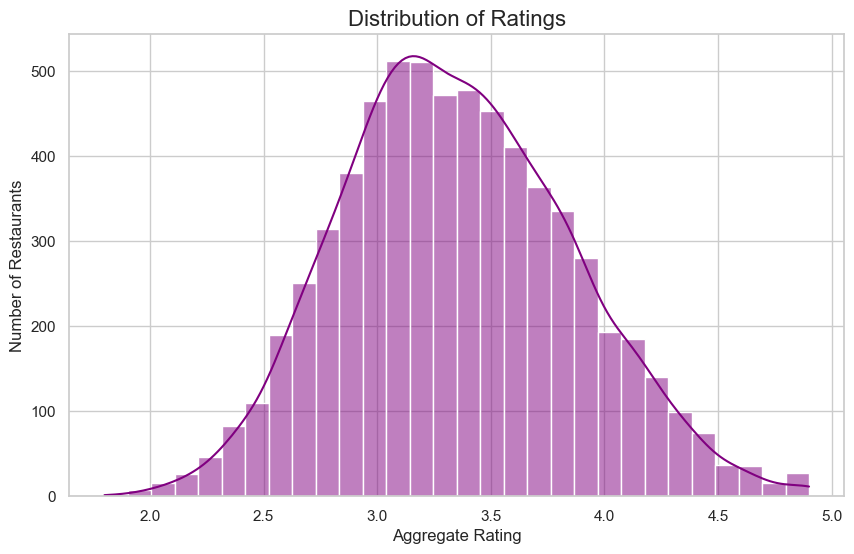

In [32]:
# plotting the distribution of ratings
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['Aggregate rating'], bins=30, kde=True, color='purple')
plt.title('Distribution of Ratings', fontsize=16)
plt.xlabel('Aggregate Rating', fontsize=12)
plt.ylabel('Number of Restaurants', fontsize=12)
plt.show()

### 3.2. Relationship Between Votes & Rating

A **Scatter Plot** is perfect for visualizing the relationship between `Votes` and `Aggregate rating`. The initial plot is skewed, so I will apply a **logarithmic scale** to the x-axis (`plt.xscale('log')`) to reveal the true positive correlation.

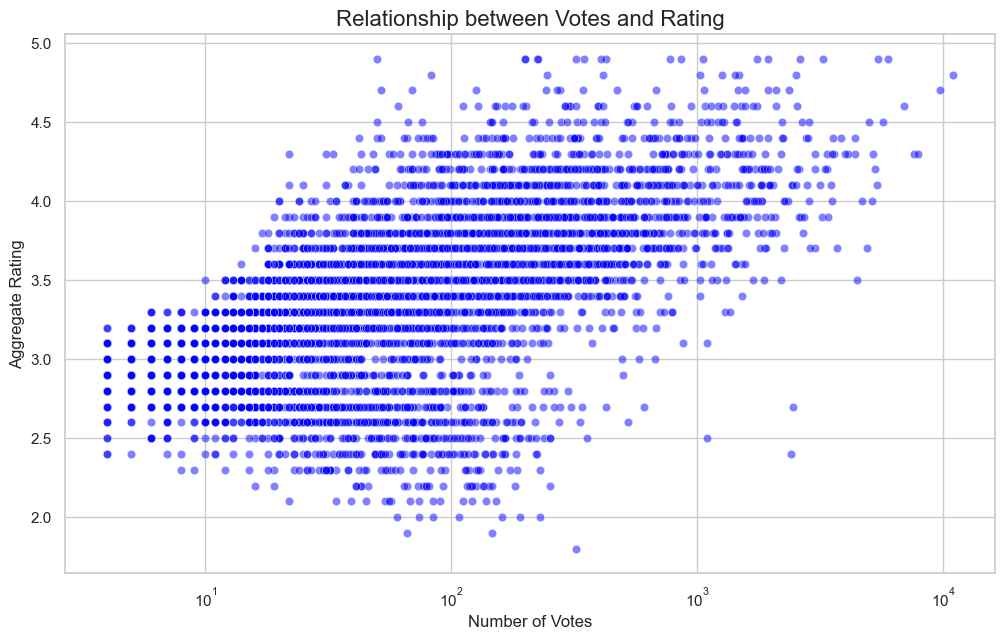

In [33]:
# correlation between votes and rating
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_clean, x='Votes', y='Aggregate rating', alpha=0.5, color='blue')
plt.xscale('log')
plt.title('Relationship between Votes and Rating', fontsize=16)
plt.xlabel('Number of Votes', fontsize=12)
plt.ylabel('Aggregate Rating', fontsize=12)
plt.show()

### 3.3. Analyzing Categorical Features

**Box Plots** are the best way to compare a numeric variable (Rating) across a categorical one (Yes/No). I'll use this to compare the ratings of restaurants *with* and *without* `Online Delivery` and `Table Booking`.

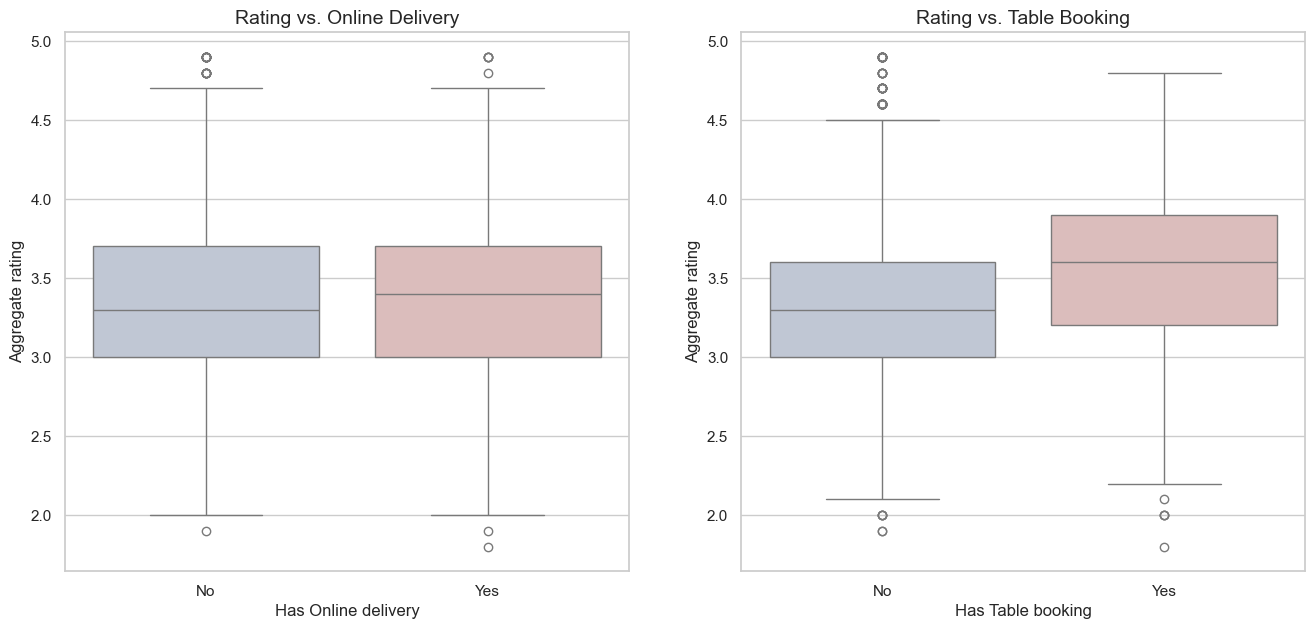

In [34]:
# correlation between rating with online delivery and table bookings
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
sns.boxplot(data=df_clean,x='Has Online delivery',y='Aggregate rating',ax=ax1,palette="vlag",hue='Has Online delivery',legend=False)
ax1.set_title('Rating vs. Online Delivery', fontsize=14)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['No', 'Yes'])
sns.boxplot(data=df_clean,x='Has Table booking',y='Aggregate rating',ax=ax2,palette="vlag",hue='Has Table booking',legend=False)
ax2.set_title('Rating vs. Table Booking', fontsize=14)
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['No', 'Yes'])
plt.show()

### 3.4. Top Cuisines

A **Bar Chart** will show the Top 10 most common `Primary Cuisine` types in the dataset.

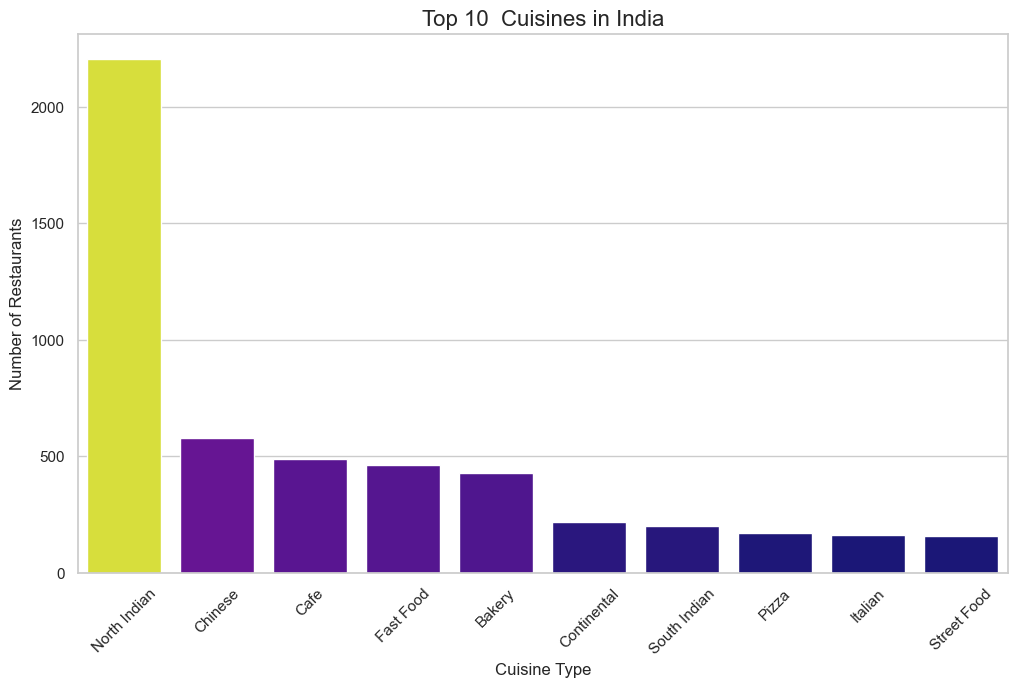

In [35]:
# top cuisines
top_cuisines = df_clean['Primary Cuisine'].value_counts().head(10)

plt.figure(figsize=(12, 7))
sns.barplot(x=top_cuisines.index,y=top_cuisines.values,palette="plasma",hue=top_cuisines,legend=False)
plt.title('Top 10  Cuisines in India', fontsize=16)
plt.xlabel('Cuisine Type', fontsize=12)
plt.ylabel('Number of Restaurants', fontsize=12)
plt.xticks(rotation=45)
plt.show()

### 3.5. Correlation Heatmap

Finally, I'll create a **Correlation Matrix Heatmap** for all numeric variables. This single chart quantifies the relationships we've seen, showing the Pearson correlation coefficient for every pair of features.

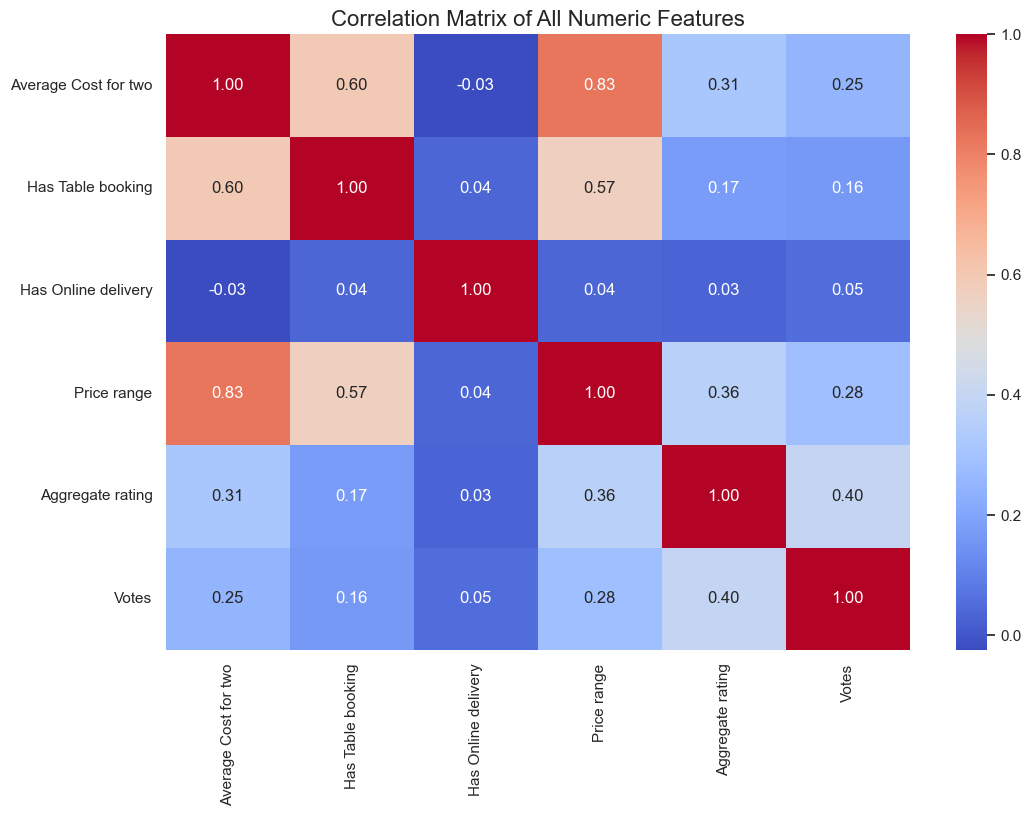

In [36]:
# correlation matrix and heatmap
numeric_df = df_clean.drop('Is delivering now', axis=1)
correlation_matrix = numeric_df.corr(method='pearson', numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix,annot=True,cmap='coolwarm',fmt='.2f')
plt.title('Correlation Matrix of All Numeric Features', fontsize=16)
plt.show()

## Phase 4: Inferential Statistics (Hypothesis Testing)

My EDA suggested relationships. This phase will use statistical tests to prove them. I'll use a standard significance level of **alpha = 0.05**.

### 4.1. Test 1: Two-Sample T-Test
* **Question:** Is the difference in mean ratings between restaurants with and without `Table booking` statistically significant?
* **Null Hypothesis ($H_0$):** There is NO significant difference in mean ratings.
* **Alternative Hypothesis ($H_1$):** There IS a significant difference in mean ratings.

In [37]:
ratings_with_booking = df_clean[df_clean['Has Table booking'] == 1]['Aggregate rating']
ratings_without_booking = df_clean[df_clean['Has Table booking'] == 0]['Aggregate rating']

print(f"Mean rating WITH table booking: {ratings_with_booking.mean():.2f}")
print(f"Mean rating WITHOUT table booking: {ratings_without_booking.mean():.2f}")

# two-sample t-test
t_statistic, p_value = stats.ttest_ind(ratings_with_booking, ratings_without_booking, equal_var=False)

print(f"\nT-statistic: {t_statistic:.4f}")
print(f"P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("\nVerdict: The p-value is less than 0.05. We REJECT the Null Hypothesis (H_0).")
    print("Conclusion: The difference in ratings is statistically significant.")
else:
    print("\nVerdict: The p-value is greater than 0.05. We FAIL TO REJECT the Null Hypothesis (H_0).")
    print("Conclusion: The difference in ratings is not statistically significant.")

Mean rating WITH table booking: 3.55
Mean rating WITHOUT table booking: 3.31

T-statistic: 13.9314
P-value: 1.5473955541330712e-41

Verdict: The p-value is less than 0.05. We REJECT the Null Hypothesis (H_0).
Conclusion: The difference in ratings is statistically significant.


### 4.2. Test 2: Chi-Square ($\chi^2$) Test
* **Question:** Is there a significant association between a restaurant's `City` and its `Price range`?
* **Null Hypothesis ($H_0$):** There is NO association. `City` and `Price range` are independent.
* **Alternative Hypothesis ($H_1$):** There IS an association. They are dependent.

In [38]:
# relationship between top 5 cities and price range
top_5_cities = df_clean['City'].value_counts().head(5).index

df_top5 = df_clean[df_clean['City'].isin(top_5_cities)]
contingency_table = pd.crosstab(df_top5['City'], df_top5['Price range'])
print(contingency_table)

# chi square test
chi2_stat, p_value, dof, expected_values = stats.chi2_contingency(contingency_table)
print(f"\nChi-Square Statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("\nVerdict: The p-value is less than 0.05. We REJECT the Null Hypothesis (H_0).")
    print("Conclusion: There IS a statistically significant association between City and Price Range.")
else:
    print("\nVerdict: The p-value is greater than 0.05. We FAIL TO REJECT the Null Hypothesis (H_0).")
    print("Conclusion: There is NO statistically significant association between City and Price Range.")

Price range     1     2    3    4
City                             
Faridabad      77    64   10    0
Ghaziabad       7    13    2    1
Gurgaon       288   380  157   65
New Delhi    1873  1438  527  210
Noida         286   305   87   18

Chi-Square Statistic: 100.3016
P-value: 4.859406976023205e-16

Verdict: The p-value is less than 0.05. We REJECT the Null Hypothesis (H_0).
Conclusion: There IS a statistically significant association between City and Price Range.


## Phase 5: Supervised Learning (Simple Linear Regression)

Now I will move from analysis to prediction. I'll build a **Simple Linear Regression** model to predict `Aggregate rating`.

* **Target (y):** `Aggregate rating`
* **Feature (X):** `Votes` (which I'll log-transform to `Votes_log` to improve the model)

I'll split the data into an 80% Training set and a 20% Testing set.

In [39]:
data_for_ml = df_clean.copy()
data_for_ml['Votes_log'] = np.log(data_for_ml['Votes'] + 1)

X = data_for_ml[['Votes_log']]
y = data_for_ml['Aggregate rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data size: {X_train.shape[0]} rows")
print(f"Testing data size: {X_test.shape[0]} rows")

# model creation and training
lr_model = LinearRegression()

lr_model.fit(X_train, y_train)
print("\nModel training complete.")

# predictions
y_pred = lr_model.predict(X_test)
print("\nPredictions made on the test set.")

Training data size: 5203 rows
Testing data size: 1301 rows

Model training complete.

Predictions made on the test set.


### 5.1. Model Evaluation

I'll evaluate the model using two key metrics:
1.  **R-squared ($R^2$):** What percentage of the variance in `Rating` can be explained by `Votes_log`?
2.  **Mean Absolute Error (MAE):** On average, how many "stars" is our prediction wrong by?

I'll also plot the **Actual vs. Predicted** values to visually assess the model's performance.

R-squared (R^2): 0.4131

Mean Absolute Error (MAE): 0.2852
Rating = 0.2138 * log(Votes + 1) + 2.4897


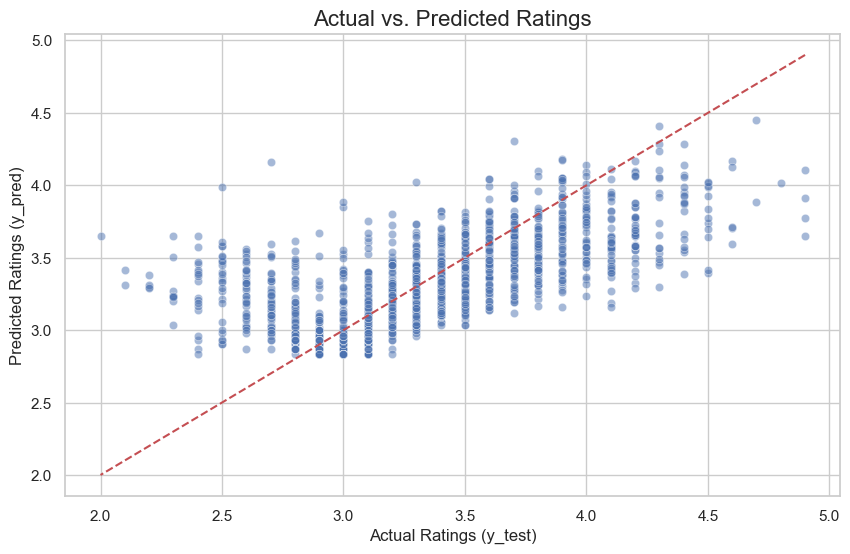

In [40]:
# model evaluation
r2 = metrics.r2_score(y_test, y_pred) # R-squared
mae = metrics.mean_absolute_error(y_test, y_pred) # Mean Absolute Error

print(f"R-squared (R^2): {r2:.4f}")
print(f"\nMean Absolute Error (MAE): {mae:.4f}")

m = lr_model.coef_[0]
b = lr_model.intercept_

print(f"Rating = {m:.4f} * log(Votes + 1) + {b:.4f}") # regression equation

# model's performance
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'r--')

plt.title('Actual vs. Predicted Ratings', fontsize=16)
plt.xlabel('Actual Ratings (y_test)', fontsize=12)
plt.ylabel('Predicted Ratings (y_pred)', fontsize=12)

plt.show()

## Phase 6: K-Means Clustering

My final analysis is **Market Segmentation**. I'll use **K-Means Clustering** to find natural groups of restaurants based on `Average Cost for two` and `Aggregate rating`.

### 6.1. The Elbow Method

First, I must find the optimal number of clusters(K). I'll use the **Elbow Method**, plotting the inertia for K=1 through K=10. The elbow of the curve will show the best K.

*Note: The data must be scaled using `StandardScaler` before clustering, as K-Means is distance-based.*

Data scaled successfully.
Elbow method calculations complete.


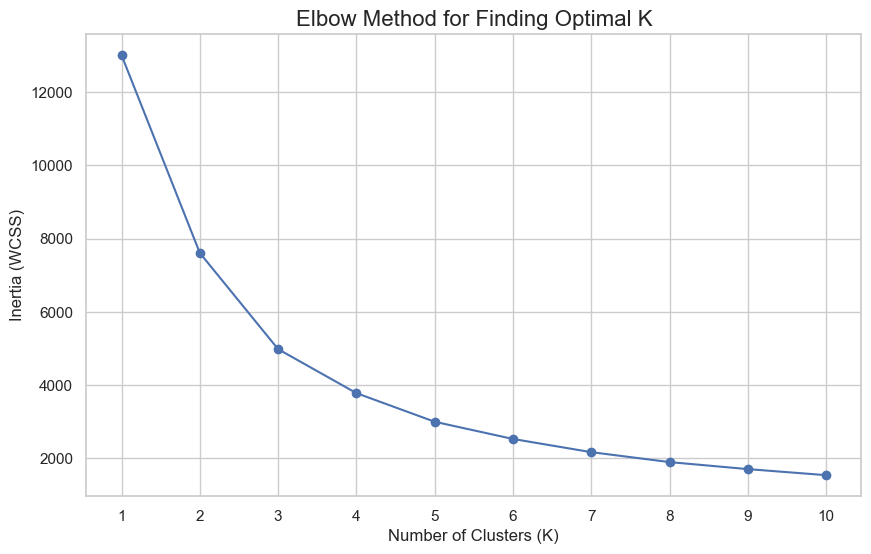

In [41]:
os.environ['LOKY_MAX_CPU_COUNT'] = '4' 

cluster_data = df_clean[['Average Cost for two', 'Aggregate rating']]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)
print("Data scaled successfully.")

# optimal K (elbow method)
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) 
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

print("Elbow method calculations complete.")

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia (WCSS)', fontsize=12)
plt.title('Elbow Method for Finding Optimal K', fontsize=16)
plt.xticks(K_range)
plt.show()

### 6.2. Final Cluster Visualization

The Elbow Plot clearly shows an optimal **K=4**.

I'll now run the final `KMeans` model with 4 clusters and plot the results on a scatter plot.
This will visually reveal the four distinct market segments.

K-Means (K=4) complete. Cluster labels assigned.


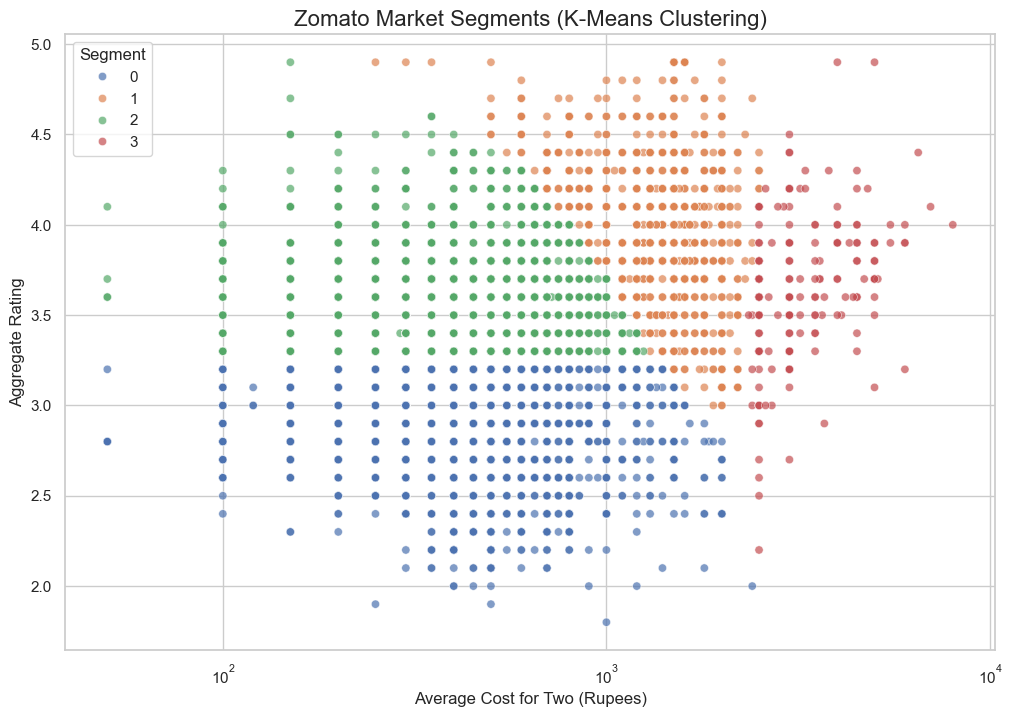

In [42]:
# final K-means model with K=4
os.environ['LOKY_MAX_CPU_COUNT'] = '4'

final_kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
final_kmeans.fit(scaled_data)

cluster_labels = final_kmeans.labels_
df_clean['Cluster'] = cluster_labels

print("K-Means (K=4) complete. Cluster labels assigned.")

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_clean,x='Average Cost for two',y='Aggregate rating',hue='Cluster',palette='deep',alpha=0.7)

plt.title('Zomato Market Segments (K-Means Clustering)', fontsize=16)
plt.xlabel('Average Cost for Two (Rupees)', fontsize=12)
plt.ylabel('Aggregate Rating', fontsize=12)
plt.legend(title='Segment')
plt.xscale('log') 
plt.show()

## Phase 7: Final Conclusion

This project successfully navigated the full data science workflow.

1.  I cleaned a messy, real-world dataset, making key strategic decisions to scope the analysis.
2.  I uncovered strong insights through EDA, such as the importance of `Votes` and `Table booking` (which I later proved statistically).
3.  I built a regression model and, more importantly, *critically evaluated* its performance (R² = 0.41), concluding it's a good diagnostic tool but too simple for production.
4.  I finished by discovering four distinct market segments—"Budget Gems," "Mainstream Hits," "The Average Crowd," and "Premium & Luxury"—using K-Means clustering.